<a href="https://colab.research.google.com/github/iuricimatec/depthmap/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import os


# to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/CIMATEC/MCTI/BOLSA/SoftArm/dataset/EDA/'

Mounted at /content/gdrive


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
df = pd.read_csv(path + 'output/preprocessed.csv')
df.head()

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_perimeter,cam1_circle_radius,cam1_ellipse_area,cam1_ellipse_perimeter,cam1_fast,cam1_harris,...,cam3_ellipse_perimeter,cam3_fast,cam3_harris,cam3_shitomasi,Engine1,Engine2,Engine3,Engine4,Engine5,Engine6
0,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,1531.0,199204.0,...,48.57,1531.0,199204.0,303.0,10,10,10,10,10,10
1,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,8654.0,199204.0,...,48.57,8654.0,199204.0,303.0,10,10,10,10,10,10
2,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,8654.0,199204.0,...,48.57,8654.0,199204.0,303.0,10,10,10,10,10,10
3,1035.0,0.0,0.00,0.0,4.0,0.000100,0.00,0.00,8586.0,198264.0,...,0.00,8586.0,198264.0,314.0,10,10,10,10,10,10
4,1035.0,0.0,0.00,0.0,4.0,0.000100,0.00,0.00,8586.0,198264.0,...,0.00,8586.0,198264.0,314.0,10,10,10,10,10,10


In [5]:
# df = df.reset_index()
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# running the function
clean_dataset(df)    

,cam1_canny,cam1_area,cam1_perimeter,cam1_angle,cam1_rect_straigth_perimeter,cam1_circle_radius,cam1_ellipse_area,cam1_ellipse_perimeter,cam1_fast,cam1_harris,...,cam3_ellipse_perimeter,cam3_fast,cam3_harris,cam3_shitomasi,Engine1,Engine2,Engine3,Engine4,Engine5,Engine6
0,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,1531.0,199204.0,...,48.57,1531.0,199204.0,303.0,10.0,10.0,10.0,10.0,10.0,10.0
1,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,8654.0,199204.0,...,48.57,8654.0,199204.0,303.0,10.0,10.0,10.0,10.0,10.0,10.0
2,1047.0,125.5,51.21,86.2,60.0,9.708344,139.41,48.57,8654.0,199204.0,...,48.57,8654.0,199204.0,303.0,10.0,10.0,10.0,10.0,10.0,10.0
3,1035.0,0.0,0.00,0.0,4.0,0.000100,0.00,0.00,8586.0,198264.0,...,0.00,8586.0,198264.0,314.0,10.0,10.0,10.0,10.0,10.0,10.0
4,1035.0,0.0,0.00,0.0,4.0,0.000100,0.00,0.00,8586.0,198264.0,...,0.00,8586.0,198264.0,314.0,10.0,10.0,10.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,785.0,108.5,48.38,85.8,56.0,8.747321,130.52,46.33,4318.0,209569.0,...,46.33,4318.0,209569.0,141.0,2486.0,1758.0,279.0,1213.0,1365.0,2240.0
1043,785.0,108.5,48.38,85.8,56.0,8.747321,130.52,46.33,4318.0,209569.0,...,46.33,4318.0,209569.0,141.0,2486.0,1758.0,279.0,1213.0,1530.0,2240.0
1044,762.0,110.0,48.97,86.8,56.0,8.875433,131.53,46.40,4373.0,209699.0,...,46.40,4373.0,209699.0,152.0,2486.0,1758.0,279.0,1213.0,1530.0,2240.0
1045,762.0,110.0,48.97,86.8,56.0,8.875433,131.53,46.40,4373.0,209699.0,...,46.40,4373.0,209699.0,152.0,2486.0,1758.0,279.0,1591.0,1530.0,2240.0


### Train-val-test dataset split

In [6]:
train, test = train_test_split(df, test_size=0.15, shuffle=False)

train, val = train_test_split(train, test_size=0.15, shuffle=False)

#train data
X_train = train.iloc[:,:-6]
y_train = train.iloc[:,-6:]

#val data
X_val = val.iloc[:,:-6]
y_val = val.iloc[:,-6:]

#test data
X_test = test.iloc[:,:-6]
y_test = test.iloc[:,-6:]

### Dataset scaling

In [7]:
def scale_features(train_features, val_features, test_features, feature_range = (-1, 1)):
    scaler = MinMaxScaler(feature_range=feature_range)
#     scaler = StandardScaler()
    scaler.fit(train_features)
    train_feature_scaled = scaler.transform(train_features)
    val_feature_scaled = scaler.transform(val_features)
    test_feature_scaled = scaler.transform(test_features)
    return scaler, train_feature_scaled, val_feature_scaled, test_feature_scaled

x_scaler, X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train, 
                                                                       X_val, 
                                                                       X_test, 
                                                                       feature_range=(-1, 1)
                                                                      )

y_scaler, y_train_scaled, y_val_scaled, y_test_scaled = scale_features(y_train, 
                                                                       y_val, 
                                                                       y_test, 
                                                                       feature_range=(-1, 1)
                                                                      )

In [8]:
def transformer_encoder(inputs, head_size, value_dim, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, 
        value_dim=value_dim, 
        num_heads=num_heads, 
        dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

#     Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
#     x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [9]:
def build_model(
    input_shape,
    head_size,
    value_dim,
    num_heads,
    ff_dim,
    dropout=0,
    num_transformer_blocks=2):
    
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    outputs = []
    for i in range(6):
        output = layers.Dense(1, activation='tanh')(x)
        outputs.append(output)
    outputs = layers.concatenate(outputs, axis=1)
    model = Model(inputs, outputs)

    return model

In [10]:
X_train_scaled.shape

(755, 36)

In [11]:
input_shape = (X_train_scaled.shape[-1], 1)

model = build_model(
        input_shape,
        head_size=40,
        num_heads=8,
        value_dim=40,
        ff_dim=8,
        dropout=0.0,
        num_transformer_blocks=3
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 36, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 36, 1)       1473        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [12]:
model.compile(optimizer='adam', 
              metrics=['mae'], 
              loss=['mse']
)

reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', 
                            factor=0.1,
                            patience=25, 
                            min_lr=1e-6
)

history_model = model.fit(
                        X_train_scaled, 
                        y_train_scaled, 
                        validation_data=(X_val_scaled, y_val_scaled),
                        epochs=300, 
                        batch_size=32, 
                        verbose=1, 
                        callbacks=[reduce_lr]
)

Epoch 1/300
24/24 [==============================] - 7s 84ms/step - loss: 0.5451 - mae: 0.6038 - val_loss: 0.5721 - val_mae: 0.6489 - lr: 0.0010
Epoch 2/300
24/24 [==============================] - 2s 66ms/step - loss: 0.4547 - mae: 0.5595 - val_loss: 0.5288 - val_mae: 0.6378 - lr: 0.0010
Epoch 3/300
24/24 [==============================] - 2s 103ms/step - loss: 0.4139 - mae: 0.5402 - val_loss: 0.4959 - val_mae: 0.6205 - lr: 0.0010
Epoch 4/300
24/24 [==============================] - 3s 104ms/step - loss: 0.3970 - mae: 0.5307 - val_loss: 0.4675 - val_mae: 0.6032 - lr: 0.0010
Epoch 5/300
24/24 [==============================] - 2s 65ms/step - loss: 0.3857 - mae: 0.5274 - val_loss: 0.4555 - val_mae: 0.5928 - lr: 0.0010
Epoch 6/300
24/24 [==============================] - 2s 65ms/step - loss: 0.3791 - mae: 0.5233 - val_loss: 0.4449 - val_mae: 0.5874 - lr: 0.0010
Epoch 7/300
24/24 [==============================] - 2s 66ms/step - loss: 0.3734 - mae: 0.5218 - val_loss: 0.4366 - val_mae: 0.5

In [24]:
model.save(path + 'output/models/transformer.h5')

### Model evaluation

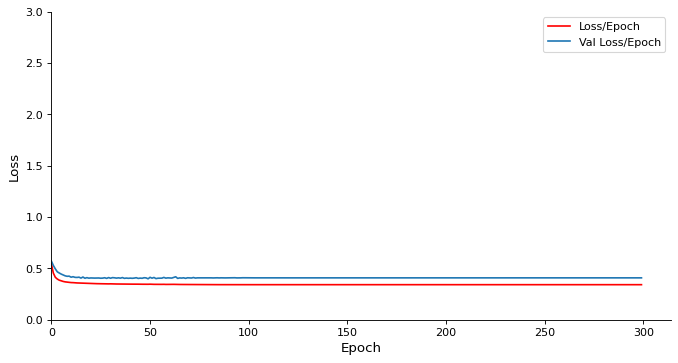

In [25]:
f, ax = plt.subplots(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.plot(history_model.history['loss'], label="Loss/Epoch", color='red')
ax.plot(history_model.history['val_loss'], label="Val Loss/Epoch")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 3)
ax.set_xlim(-0.2,)
plt.legend()
plt.show()

In [26]:
y_predito = model.predict(X_test_scaled)
predito_normal = y_scaler.inverse_transform(y_predito)

5/5 [==============================] - 0s 31ms/step


In [18]:
loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f'loss: {round(loss, 2)} \nmae: {round(mae, 2)}')

5/5 [==============================] - 0s 31ms/step - loss: 0.3723 - mae: 0.5313
loss: 0.37 
mae: 0.53


In [19]:
def allmetrics(original, predito):
    slope, intercept, r_value, p_value, std_err = stats.linregress(original, predito)
    mae = mean_absolute_error(original, predito)
    mse = mean_squared_error(original, predito, squared=True)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(original, predito)
    rr = r2_score(original,predito)
    pea = stats.pearsonr(original, predito)
    nmse = mse/stats.tstd(original)
    return mae, rmse, nmse, mape, r_value, rr

In [20]:
valores = []

for i in range(6):  
    mae, rmse, nmse, mape, r_value, rr = allmetrics(y_test.iloc[:,i], predito_normal[:,i])
    valores.append([f"Engine {1+i}", mae, rmse, nmse, mape, r_value])
erros = pd.DataFrame(valores)
erros.columns = ['Engine ID', 'MAE','RMSE','NMSE', 'MAPE', 'R']
mean = erros.iloc[:,1:].mean().values.tolist()
mean.insert(0, 'Mean')
mean[-1] = None
erros.loc[len(erros)] = mean
erros[erros.columns[1:]] = erros[erros.columns[1:]].astype(float)

erros.round(2)

,Engine ID,MAE,RMSE,NMSE,MAPE,R
0,Engine 1,555.53,672.50,656.16,1.73,0.23
1,Engine 2,679.32,787.72,882.01,1.00,0.20
2,Engine 3,773.75,846.93,870.17,1.66,-0.13
3,Engine 4,611.31,694.30,724.18,6.12,0.41
4,Engine 5,734.60,818.72,835.76,1.74,-0.05
5,Engine 6,599.66,704.60,722.48,2.27,0.02
6,Mean,659.03,754.13,781.79,2.42,NaN


### Plotting results

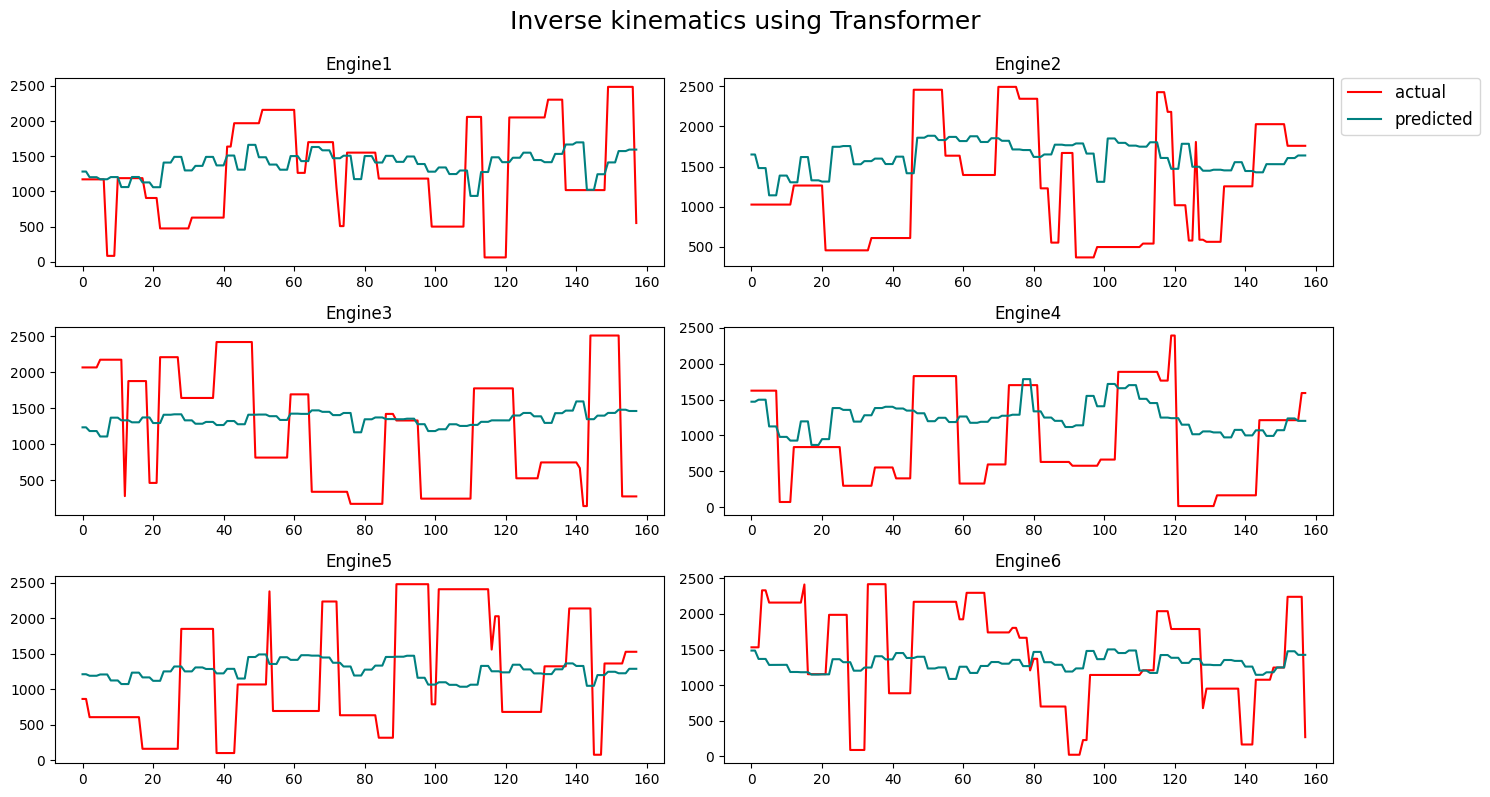

In [21]:
def plot_graphs(y_test=y_test, y_true=predito_normal, title='Inverse kinematics using Transformers'):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=18, y=0.99)

    for ax, i in zip(axs.ravel(), range(6)):
        sns.lineplot(y_test.iloc[:, i].values, ax=ax, label='actual', color='red', linewidth=1.5)
        sns.lineplot(predito_normal[:, i], ax=ax, label='predicted', color='teal', linewidth=1.5)

        ax.set_title(f'Engine{i + 1}')
        if ax == axs[0][1]:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.85), fontsize=12)
        else:
            ax.get_legend().remove()
            
    plt.tight_layout()
    plt.show()

plot_graphs(title='Inverse kinematics using Transformer')

### The Error distribution

In order to know whether or not the performance of the model is acceptable, the error must follow a gaussian distribution with mean zero. Bellow, we can see that the distribution of the errors follow quite closely a gaussian distribution with mean virtually closed to zero.

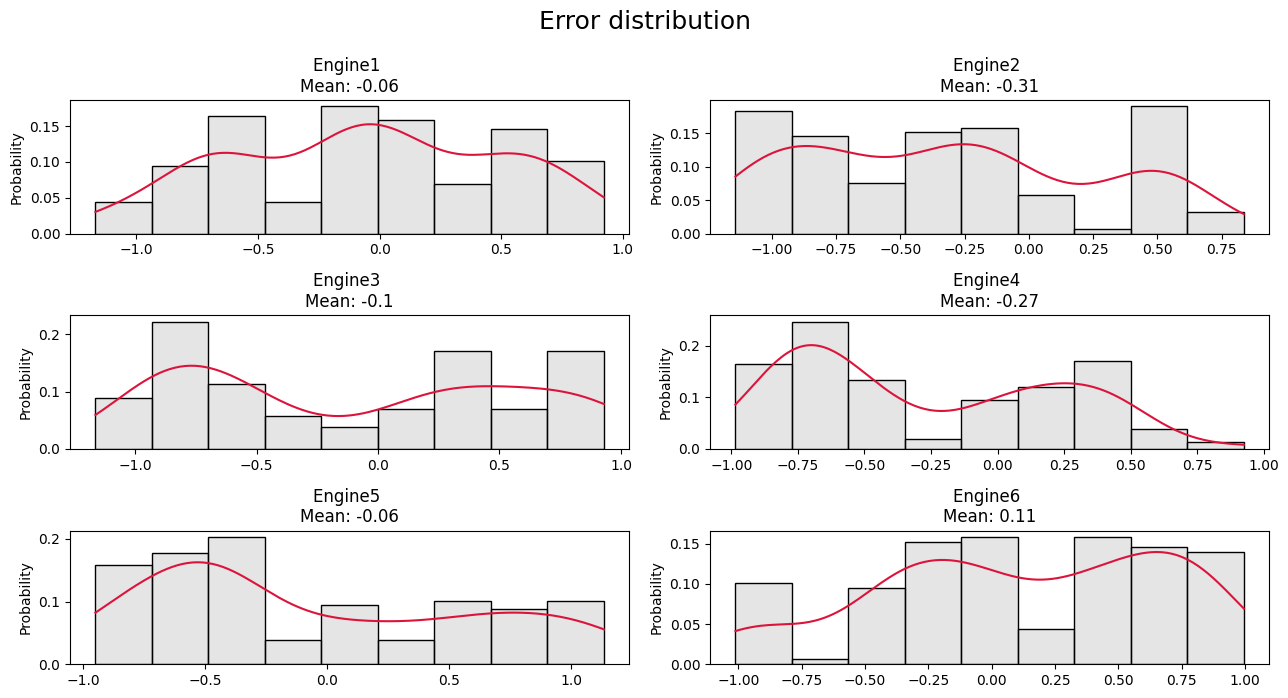

In [22]:
def plot_residuals(y_true, y_pred, title='Error distribution'):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13, 7))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=18, y=0.99)

    for ax, i in zip(axs.ravel(), range(6)):
        errors = y_true[:, i] - y_pred[:, i]
        mean = np.round(np.mean(errors), 2)

        sns.histplot(data=errors, color='0.8', ax=ax, stat='probability', kde=True)
        ax.lines[0].set_color('crimson')
     
        ax.set_title(f'Engine{i + 1} \nMean: {mean}')
    plt.tight_layout()
    plt.show()

plot_residuals(y_true=y_test_scaled, y_pred=y_predito, title='Error distribution')